Finite differences

B(r0,0) ≈ 254.6189


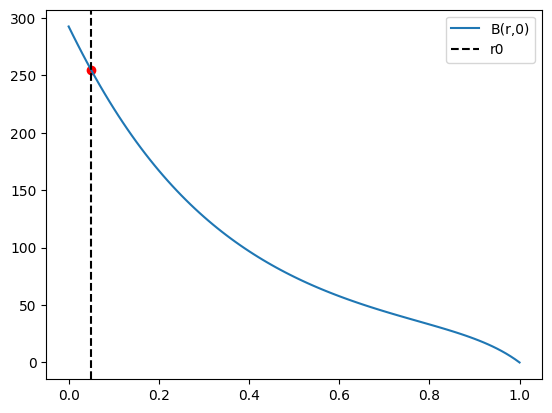

In [75]:
# Continuous-coupon bond pricing via Crank–Nicolson (refactored)
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time    

# Function to initialise the grid
def initialise_grid(r_max = 1.0, N_r = 100, N_t = 100, T = 4.0):
    dr = r_max / N_r
    dt = T / N_t
    r_vals = np.linspace(0.0, r_max, N_r + 1)
    t_vals = np.linspace(0.0, T, N_t + 1)
    return r_vals, t_vals, dr, dt

def thomas_solver(sub, diag, sup, rhs):
    n = len(rhs)
    cp = np.zeros(n)
    dp = np.zeros(n)
    cp[0] = sup[0] / diag[0]
    dp[0] = rhs[0] / diag[0]
    for i in range(1, n):
        m = diag[i] - sub[i] * cp[i-1]
        cp[i] = sup[i] / m if i < n-1 else 0.0
        dp[i] = (rhs[i] - sub[i] * dp[i-1]) / m
    x = np.zeros(n)
    x[-1] = dp[-1]
    for i in range(n-2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i+1]
    return x

def crank_nicolson_layer(next_layer, ti, dr, dt, grid, model):
    # Declare all arrays as arrays containing 0, initially, later to be edited
    N = len(grid["r"])
    a = np.zeros(N)
    b = np.zeros(N)
    c = np.zeros(N)
    d = np.zeros(N)
    
    # Get all necessary values from the model dict
    T, F, theta, kappa, mu, sigma, beta, Cc, alpha = model["T"], model["F"], \
        model["theta"], model["kappa"], model["mu"], model["sigma"], model["beta"], model["C"], model["alpha"]
    
    # Coupon time-averaged
    coup_t  = Cc * np.exp(-alpha * ti)
    coup_tp = Cc * np.exp(-alpha * (ti + dt))
    coup_cn = 0.5 * dt * (coup_t + coup_tp)
    
    # Iterate through N - 1, assign rj for every iteration
    for j in range(1, N-1):
        rj = grid["r"][j]
        diff   = 0.5 * sigma**2 * rj**(2 * beta)
        drift_t   = kappa * (theta * np.exp(mu * ti)     - rj)
        drift_tp  = kappa * (theta * np.exp(mu * (ti+dt))- rj)
        
        alpha_p = diff * dt / dr**2
        beta_p  = drift_tp * dt / (2 * dr)
        alpha_n = diff * dt / dr**2
        beta_n  = drift_t * dt / (2 * dr)
        
        a[j] = -0.5 * (alpha_p - beta_p)
        b[j] = 1.0 + 0.5*(2*alpha_p + rj*dt)
        c[j] = -0.5 * (alpha_p + beta_p)
        
        d[j] = ( 0.5*(alpha_n - beta_n)*next_layer[j-1]
               + (1.0 - 0.5*(2*alpha_n + rj*dt))*next_layer[j]
               + 0.5*(alpha_n + beta_n)*next_layer[j+1]
               + coup_cn )
    
    # Neumann at r = 0
    a[0] = 0.0
    b[0] = 1.0
    c[0] = 0.0
    d[0] = (next_layer[0]
           + dt*kappa*theta*np.exp(mu*ti)*(next_layer[1] - next_layer[0]) / dr
           + dt*coup_t)
    # Dirichlet at r = r_max
    a[-1] = 0.0
    b[-1] = 1.0
    c[-1] = 0.0
    d[-1] = 0.0
    
    # solve interior  from 0 to N-1
    return thomas_solver(a, b, c, d)

def price_bond(model_parameters):
    # print(1)
    r_vals, t_vals, dr, dt = initialise_grid(
        r_max = 1.0, N_r = 100, N_t = 100, T = model_parameters["T"]    
    )
    # print(2)
    grid = {"r": r_vals, "t": t_vals}
    
    B = np.zeros((len(r_vals), len(t_vals)))
    B[:, -1] = model_parameters["F"]
    
    for idx in range(len(t_vals)-2, -1, -1):
        B[:, idx] = crank_nicolson_layer(B[:, idx+1], t_vals[idx], dr, dt, grid, model_parameters)
    
    interp = interp1d(r_vals, B[:,0], kind="cubic")
    return float(interp(model_parameters["r0"])), r_vals, B[:,0]


# Declare all model parameters as a dictionary
model_parameters = {
    "T": 4.0,
    "F": 240.0,
    "theta": 0.0647,
    "kappa": 0.07224,
    "mu": -0.009,
    "sigma": 0.169,
    "beta": 0.359,
    "C": 16.0,
    "alpha": 0.03,
    "r0": 0.0499
}

# Run the code to get the result and plot the graph here
price, r_vals, B0 = price_bond(model_parameters)
print(f"B(r0,0) ≈ {price:.4f}")    # Round to 6 decimal points

plt.plot(r_vals, B0, label="B(r,0)")
plt.axvline(model_parameters["r0"], color="k", ls="--", label="r0")
plt.scatter([model_parameters["r0"]], [price], color="red")
plt.legend()
plt.show()

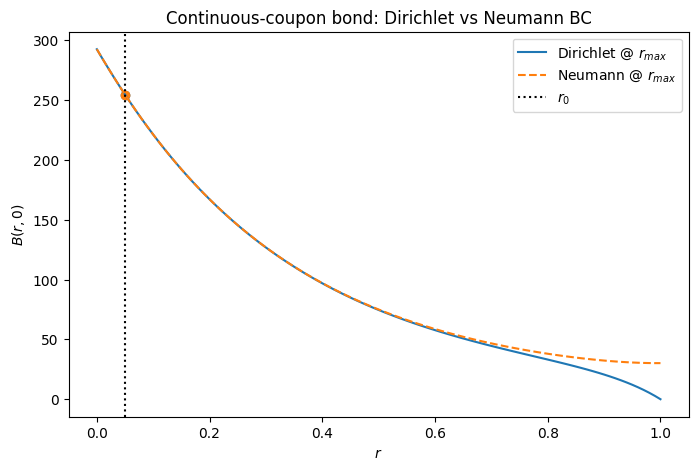

B_dirichlet(r0,0) = 254.618894
B_neumann(r0,0)   = 254.619214
r_max   Nr   Nt      Price      Error   Time (s)
  1.0   50   50 254.670377   7.27e-02      0.022
  1.0  100  100 254.618894   2.13e-02      0.082
  1.0  150  150 254.602873   5.24e-03      0.187
  1.0  200  200 254.595142   2.49e-03      0.336
  1.0  300  300 254.587650   9.98e-03      0.739


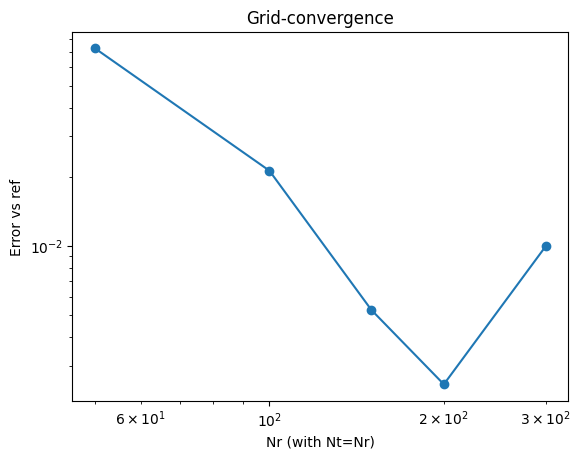

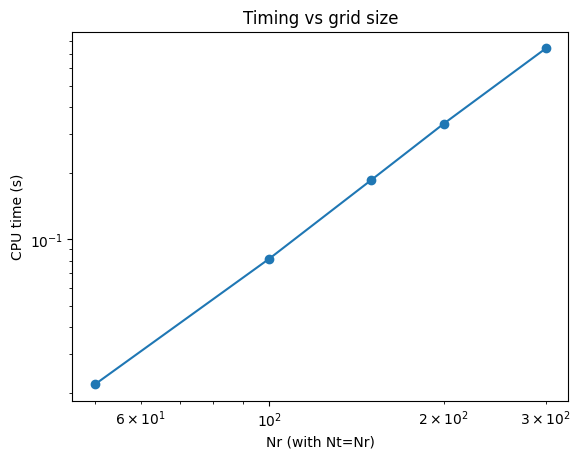

In [76]:
# A version of Crank Nicolson that uses Neumann  boundary condition at r_max
def crank_nicolson_layer_neumann(next_layer, ti, dr, dt, grid, model):
#Copying the structure from the code above with different boundary for R_max
    N = len(grid["r"])
    a = np.zeros(N)
    b = np.zeros(N)
    c = np.zeros(N)
    d = np.zeros(N)
    
    # Get all necessary values from the model dict
    T, F, theta, kappa, mu, sigma, beta, Cc, alpha = model["T"], model["F"], \
        model["theta"], model["kappa"], model["mu"], model["sigma"], model["beta"], model["C"], model["alpha"]
    
    # Coupon time-averaged
    coup_t  = Cc * np.exp(-alpha * ti)
    coup_tp = Cc * np.exp(-alpha * (ti + dt))
    coup_cn = 0.5 * dt * (coup_t + coup_tp)
    
    # Iterate through N - 1, assign rj for every iteration
    for j in range(1, N-1):
        rj = grid["r"][j]
        diff   = 0.5 * sigma**2 * rj**(2 * beta)
        drift_t   = kappa * (theta * np.exp(mu * ti)     - rj)
        drift_tp  = kappa * (theta * np.exp(mu * (ti+dt))- rj)
        
        alpha_p = diff * dt / dr**2
        beta_p  = drift_tp * dt / (2 * dr)
        alpha_n = diff * dt / dr**2
        beta_n  = drift_t * dt / (2 * dr)
        
        a[j] = -0.5 * (alpha_p - beta_p)
        b[j] = 1.0 + 0.5*(2*alpha_p + rj*dt)
        c[j] = -0.5 * (alpha_p + beta_p)
        
        d[j] = ( 0.5*(alpha_n - beta_n)*next_layer[j-1]
               + (1.0 - 0.5*(2*alpha_n + rj*dt))*next_layer[j]
               + 0.5*(alpha_n + beta_n)*next_layer[j+1]
               + coup_cn )
    
    # Neumann at r = 0
    a[0] = 0.0
    b[0] = 1.0
    c[0] = 0.0
    d[0] = (next_layer[0]
           + dt*kappa*theta*np.exp(mu*ti)*(next_layer[1] - next_layer[0]) / dr
           + dt*coup_t)
    # **Neumann at r_max
    a[-1] = -1.0   
    b[-1] = 1.0   
    c[-1] = 0.0
    d[-1] = 0.0
    return thomas_solver(a, b, c, d)

# Pricing with either boundary condition
def price_bond_bc(model_parameters, bc="dirichlet", r_max=1.0, N_r=100, N_t=100):
    r_vals, t_vals, dr, dt = initialise_grid(r_max, N_r, N_t, model_parameters["T"])
    grid = {"r": r_vals, "t": t_vals}
    B = np.zeros((len(r_vals), len(t_vals)))
    B[:, -1] = model_parameters["F"]
    for idx in range(len(t_vals)-2, -1, -1):
        if bc=="dirichlet":
            B[:, idx] = crank_nicolson_layer(B[:, idx+1], t_vals[idx], dr, dt, grid, model_parameters)
        else:
            B[:, idx] = crank_nicolson_layer_neumann(B[:, idx+1], t_vals[idx], dr, dt, grid, model_parameters)
    interp = interp1d(r_vals, B[:,0], kind="cubic")
    return interp(model_parameters["r0"]), r_vals, B[:,0]

# Overlaying Dirichlet vs Neumann
price_D, r, B_D = price_bond_bc(model_parameters, bc="dirichlet")
price_N, _, B_N = price_bond_bc(model_parameters, bc="neumann")

plt.figure(figsize=(8,5))
plt.plot(r, B_D, label="Dirichlet @ $r_{max}$")
plt.plot(r, B_N, '--', label="Neumann @ $r_{max}$")
plt.axvline(model_parameters["r0"], color='k', linestyle=':', label='$r_0$')
plt.scatter([model_parameters["r0"]], [price_D], c='C0')
plt.scatter([model_parameters["r0"]], [price_N], c='C1')
plt.xlabel("$r$")
plt.ylabel("$B(r,0)$")
plt.legend()
plt.title("Continuous‐coupon bond: Dirichlet vs Neumann BC")
plt.show()
print(f"B_dirichlet(r0,0) = {price_D:.6f}")
print(f"B_neumann(r0,0)   = {price_N:.6f}")

# grid‐convergence & timing
def price_bond_gridded(model_parameters, r_max, N_r, N_t, bc="dirichlet"):
    return price_bond_bc(model_parameters, bc=bc, r_max=r_max, N_r=N_r, N_t=N_t)[0]

# reference on a finer grid
ref_price = price_bond_gridded(model_parameters, r_max=1.5, N_r=200, N_t=200)

# grids to test
grid_list = [
    (1.0,  50,  50),
    (1.0, 100, 100),
    (1.0, 150, 150),
    (1.0, 200, 200),
    (1.0, 300, 300),
]
results = []
for rmax, Nr, Nt in grid_list:
    start = time.perf_counter()
    price = price_bond_gridded(model_parameters, rmax, Nr, Nt)
    duration = time.perf_counter() - start
    error = abs(price - ref_price)
    results.append((rmax, Nr, Nt, price, error, duration))

# print table
print(f"{'r_max':>5} {'Nr':>4} {'Nt':>4} {'Price':>10} {'Error':>10} {'Time (s)':>10}")
for rmax, Nr, Nt, price, err, t in results:
    print(f"{rmax:5.1f} {Nr:4d} {Nt:4d} {price:10.6f} {err:10.2e} {t:10.3f}")

# plot error vs grid size
sizes = [Nr for _, Nr, _ in grid_list]
errors = [err for *_, err, _ in results]
times  = [t   for *_,  _, t in results]

plt.figure()
plt.loglog(sizes, errors, marker='o')
plt.xlabel("Nr (with Nt=Nr)")
plt.ylabel("Error vs ref")
plt.title("Grid‐convergence")
plt.show()

plt.figure()
plt.loglog(sizes, times, marker='o')
plt.xlabel("Nr (with Nt=Nr)")
plt.ylabel("CPU time (s)")
plt.title("Timing vs grid size")
plt.show()


American‐put V(r0,0) ≈ 9.221518


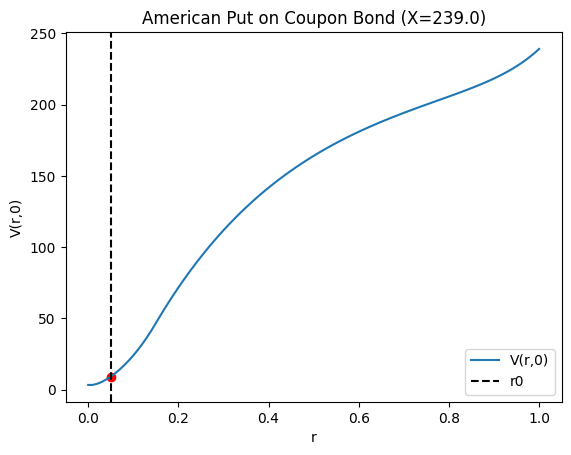

In [77]:
# PSOR solver 
def solve_psor(a, b, c, d, payoff, omega=1.2, tol=1e-8, max_iter=5000):
    n = len(d)
    V = payoff.copy()
    for _ in range(max_iter):
        err_max = 0.0
        for j in range(n):
            rj = d[j]
            if j > 0:    rj -= a[j] * V[j-1]
            rj        -= b[j] * V[j]
            if j < n-1: rj -= c[j] * V[j+1]
            delta = omega * (rj / b[j])
            v_new = V[j] + delta
            if v_new < payoff[j]:
                v_new = payoff[j]
            err = abs(v_new - V[j])
            if err > err_max:
                err_max = err
            V[j] = v_new
        if err_max < tol:
            break
    return V

# 1)  CN layer for American put, using PSOR
def crank_nicolson_layer_put(V_next, B_next, ti, dr, dt, r_vals, model, X):

    θ, κ, μ, σ, β = (
        model["theta"], model["kappa"],
        model["mu"],    model["sigma"],
        model["beta"]
    )
    N = len(r_vals)
    a = np.zeros(N); b = np.zeros(N); c = np.zeros(N); d = np.zeros(N)

    # interior equations
    for j in range(1, N-1):
        rj = r_vals[j]
        diff    = 0.5 * σ**2 * rj**(2*β)
        drift_t = κ*(θ*np.exp(μ*ti)      - rj)
        drift_tp= κ*(θ*np.exp(μ*(ti+dt)) - rj)
        α_p = diff * dt / dr**2
        β_p = drift_tp * dt / (2*dr)
        α_n = diff * dt / dr**2
        β_n = drift_t  * dt / (2*dr)

        a[j] = -0.5*(α_p - β_p)
        b[j] =  1.0 + 0.5*(2*α_p + rj*dt)
        c[j] = -0.5*(α_p + β_p)
        d[j] = (0.5*(α_n - β_n)*V_next[j-1]
              + (1.0 - 0.5*(2*α_n + rj*dt))*V_next[j]
              + 0.5*(α_n + β_n)*V_next[j+1])

    # Neumann border condition
    a[0], b[0], c[0], d[0] = 0.0, 1.0, -1.0, 0.0

    # Dirichlet BC at r_max
    a[-1], b[-1], c[-1] = 0.0, 1.0, 0.0
    d[-1] = X - B_next[-1]

    # payoff vector for PSOR
    payoff = np.maximum(X - B_next, 0.0)

    # solve LCP via PSOR
    return solve_psor(a, b, c, d, payoff)

# 2)  american_put function
def price_american_put(model, strike, r_max=1.0, N_r=100, N_t=100):
    T, T1 = model["T"], model["T1"]

    # 1) build and solve bond PDE 
    r_vals, t_vals, dr, dt = initialise_grid(r_max, N_r, N_t, T)
    B = np.zeros((N_r+1, N_t+1))
    B[:, -1] = model["F"]
    for n in range(N_t-1, -1, -1):
        B[:, n] = crank_nicolson_layer(
            B[:, n+1], t_vals[n], dr, dt,
            {"r": r_vals, "t": t_vals}, model
        )

    # 2) find the index at T1
    j1 = min(int(round(T1/dt)), N_t)

    # 3) backward induction for American put
    V = np.zeros_like(B)
    V[:, j1] = np.maximum(strike - B[:, j1], 0.0)
    for n in range(j1-1, -1, -1):
        V[:, n] = crank_nicolson_layer_put(
            V[:, n+1],   # 
            B[:, n+1],   
            t_vals[n],   
            dr, dt, r_vals, model, strike
        )

    # 4) interpolate at r0
    interp = interp1d(r_vals, V[:, 0], kind="cubic")
    price = float(interp(model["r0"]))
    return price, r_vals, V[:, 0]

# Usage remains the same:
model_parameters = {
    "T": 4.0, "T1":1.2956, "F":240.0,
    "theta":0.0647, "kappa":0.07224,
    "mu":-0.009, "sigma":0.169,
    "beta":0.359, "C":16.0,
    "alpha":0.03, "r0":0.0499
}
X = 239.0
V0, r_grid, V0_curve = price_american_put(model_parameters, X)
print(f"American‐put V(r0,0) ≈ {V0:.6f}")

# Plot as before
plt.plot(r_grid, V0_curve, label="V(r,0)")
plt.axvline(model_parameters["r0"], color='k', ls='--', label="r0")
plt.scatter([model_parameters["r0"]],[V0], color='red')
plt.xlabel("r"); plt.ylabel("V(r,0)")
plt.title(f"American Put on Coupon Bond (X={X})")
plt.legend()    
plt.show()


T1 grid index: 130, t_vals[j1] = 1.300000


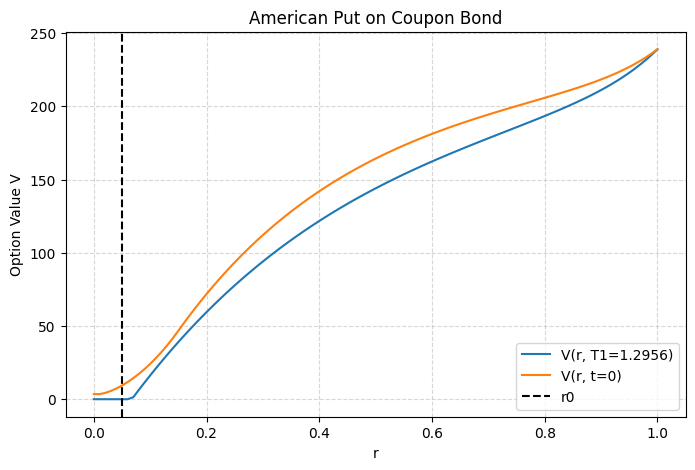

Exercise threshold at T1: r* ≈ 0.067382


In [80]:

# Task parameters
T = 4.0
T1 = 1.2956
X = 239.0
r_max = 1.0
N_r, N_t = 100, 400

# 1) Build full grid for the bond
r_vals, t_vals, dr, dt = initialise_grid(r_max, N_r, N_t, T)

# 2) Solve the bond PDE  
B = np.zeros((N_r+1, N_t+1))
B[:, -1] = model_parameters["F"]
for n in range(N_t-1, -1, -1):
    B[:, n] = crank_nicolson_layer(
        B[:, n+1],
        t_vals[n],
        dr, dt,
        {"r": r_vals, "t": t_vals},
        model_parameters
    )

# 3) Locate the option‐expiry index j1
j1 = min(int(round(T1 / dt)), N_t)
print(f"T1 grid index: {j1}, t_vals[j1] = {t_vals[j1]:.6f}")

# 4) Initialize & back‐solve the American‐put from t=T1 → t=0
V = np.zeros_like(B)
V[:, j1] = np.maximum(X - B[:, j1], 0.0)  # payoff at expiry

for n in range(j1-1, -1, -1):
    V[:, n] = crank_nicolson_layer_put(
        V[:, n+1],    
        B[:, n+1],    
        t_vals[n],
        dr, dt,
        r_vals,
        model_parameters,
        X
    )
    

# 5) Plot V at t=T1 and t=0
plt.figure(figsize=(8,5))
plt.plot(r_vals, V[:, j1], label=f"V(r, T1={T1:.4f})")
plt.plot(r_vals, V[:, 0], label="V(r, t=0)")
plt.axvline(model_parameters["r0"], color='k', ls='--', label="r0")
plt.xlabel("r")
plt.ylabel("Option Value V")
plt.title("American Put on Coupon Bond")
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# 6) Compute the exercise threshold at T1
idx = np.where(B[:, j1] < X)[0]
if idx.size > 0:
    j = idx[0]
    if j > 0:
        r_lo, r_hi = r_vals[j-1], r_vals[j]
        B_lo, B_hi = B[j-1, j1], B[j, j1]
        r_ex = r_lo + (X - B_lo)*(r_hi - r_lo)/(B_hi - B_lo)
    else:
        r_ex = r_vals[j]
    print(f"Exercise threshold at T1: r* ≈ {r_ex:.6f}")
else:
    print("No exercise region at T1.")

 r_max  N_r  N_t           V0   Time (s)
   1.0  100  100     9.221518      0.209
   1.0  200  200     9.185953      0.895
   1.0  400  400     9.136346      4.478
   1.0  800  800     9.095516     27.913
   1.0 1000 1000     9.093461     50.939

Recommended V(r0,0) ≈ 9.241005


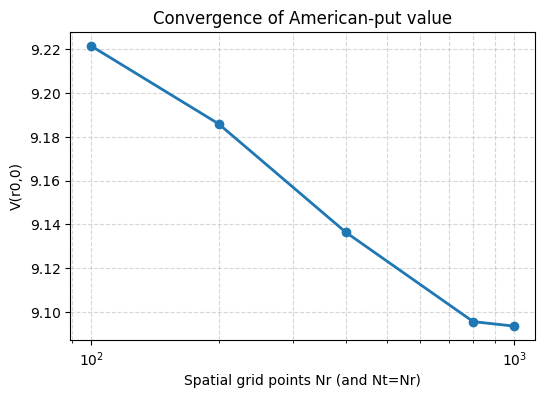

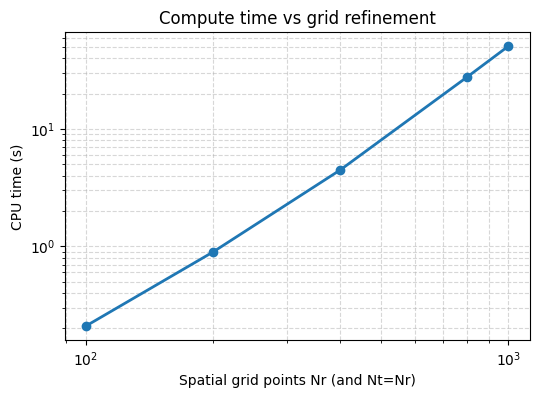

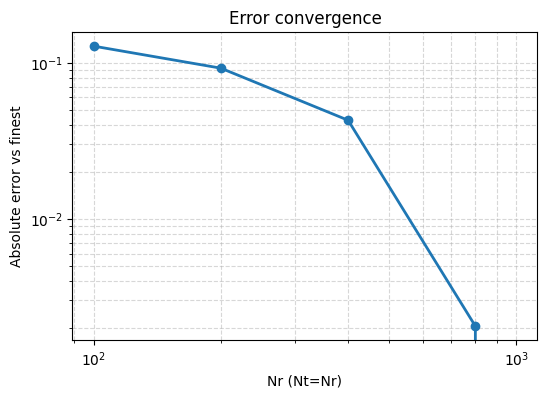

In [79]:

# Generate grid specs
grid_specs = [
    (1.0,  100,  100),
    (1.0,  200,  200),
    (1.0,  400,  400),
    (1.0,  800,  800),
    (1.0, 1000, 1000),
]

prices = []
times  = []

# 1) Compute and store prices & timings
for rmax, Nr, Nt in grid_specs:
    start = time.perf_counter()
    price, _, _ = price_american_put(model_parameters, X, rmax, Nr, Nt)
    elapsed = time.perf_counter() - start

    prices.append(price)
    times.append(elapsed)

# 2) Extract the spatial resolution 
res = [Nr for (_, Nr, _) in grid_specs]

# 3) Print the table of results
print(f"{'r_max':>6} {'N_r':>4} {'N_t':>4} {'V0':>12} {'Time (s)':>10}")
for (rmax, Nr, Nt), price, elapsed in zip(grid_specs, prices, times):
    print(f"{rmax:6.1f} {Nr:4d} {Nt:4d} {price:12.6f} {elapsed:10.3f}")

# 4) Recommended final value at a different spec
final_price, _, _ = price_american_put(model_parameters, X, 1.5, 200, 200)
print(f"\nRecommended V(r0,0) ≈ {final_price:.6f}")

# 5) Plots

# Price convergence
plt.figure(figsize=(6,4))
plt.plot(res, prices, 'o-', linewidth=2)
plt.xscale('log')
plt.xlabel('Spatial grid points Nr (and Nt=Nr)')
plt.ylabel('V(r0,0)')
plt.title('Convergence of American‐put value')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# CPU‐time vs grid size
plt.figure(figsize=(6,4))
plt.plot(res, times, 'o-', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Spatial grid points Nr (and Nt=Nr)')
plt.ylabel('CPU time (s)')
plt.title('Compute time vs grid refinement')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# Error vs grid size 
ref_price = prices[-1]
errors = [abs(p - ref_price) for p in prices]
plt.figure(figsize=(6,4))
plt.plot(res, errors, 'o-', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Nr (Nt=Nr)')
plt.ylabel('Absolute error vs finest')
plt.title('Error convergence')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()
